## Data Collection and Preprocessing

- 수집으로부터 전처리, Tagging, Topic Modeling 등의 과정을 전체적으로 테스트하는 코드입니다.

In [94]:
import os
import sys
import re
import json
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import praw

import google.generativeai as genai # Google Gemini API

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from datetime import datetime
from openai import OpenAI # OpenAI API
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation # LDA Topic Modeling

In [66]:
# environment setting

client_id = "kCbCdr1ZyxVAu9INglewcA" # reddit API
client_secret = "N3Xzl-vLnjN-53RggEkT9zUMTJ7gxw" # reddit API
user_agent = "mr_xuan_" # reddit API

# API 설정
reddit = praw.Reddit(
    client_id = client_id,
    client_secret = client_secret,
    user_agent = user_agent
)

### Data Collection

In [67]:
# 데이터 수집 설정
target_subreddit = "consoles"
search_keyword = "nintendo switch"
post_limit = 1
review_lst = []

for submission in reddit.subreddit(target_subreddit).search(search_keyword, limit=post_limit):
    # 게시글 정보 수집
    
    submission.comments.replace_more(limit=None)

    # 제한 없이 모든 댓글 수집
    for comment in submission.comments.list():
        comment_info = {
            "Type": "Comment",
            "ID": comment.id,
            "Parent_ID": comment.parent_id,
            # "Author": str(comment.author),
            "Author" : comment.author.name if comment.author else "[deleted]",
            "User_ID" : getattr(comment, "author_fullname", "N/A"),
            "Body": comment.body,
            "Score": comment.score,
            "Date": datetime.fromtimestamp(comment.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
            "URL": f"https://www.reddit.com{comment.permalink}"
        }
        review_lst.append(comment_info)

df = pd.DataFrame(review_lst)

# df.to_excel('./reddit_reviews.xlsx')

### NLP preprocessing

In [68]:
def clean_text(text):
    if not isinstance(text, str): return ""
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) # URL 제거
    text = re.sub(r'u/\S+', '', text) # 유저 태그 제거
    text = text.replace('\n', ' ') # 줄바꿈 제거
    text = re.sub(r'\s+', ' ', text).strip() # 다중 공백 제거
    return text

def nlp_preprocess(df):
    # 기본 필터링
    df = df[df['Author'] != 'AutoModerator']
    df = df[~df['Body'].isin(['[deleted]', '[removed]'])]
    
    # "mass deleted" 포함
    df = df[~df['Body'].astype(str).str.contains("mass deleted", case = False)]

    df['cleaned_Body'] = df['Body'].apply(clean_text)

    # 너무 짧을 경우 삭제
    df['word_count'] = df['cleaned_Body'].apply(lambda x: len(str(x).split()))
    df = df[df['word_count'] >= 10] # 기준을 10으로 한다. -> 10 이하의 단어로 구성된 문장은 제거

    return df

In [69]:
df = nlp_preprocess(df)

# df.to_excel('check_reddit_reviews.xlsx', index = False)

### LLM-Tagging

In [ ]:
# 기본 세팅

GOOGLE_API_KEY = "API_KEY" # Google Generative AI API Key
genai.configure(api_key=GOOGLE_API_KEY)

model = genai.GenerativeModel(
    'gemini-2.5-flash-lite',
    generation_config={
        'response_mime_type' : 'application/json'
        }
)

OPENAI_API_KEY = "API_KEY" # OpenAI API Key
client = OpenAI(api_key = OPENAI_API_KEY)

In [71]:
def get_gemini_tags(review_text):
    prompt = f"""
        You are an expert User Researcher for a new handheld gaming console.
        Analyze the following user review to build a "User Profile" for clustering.

        Review: "{review_text}"

        Task:
        1. **Noise Filter**: If the review is vague, meaningless (e.g., "Wizardry man", "Just wow"), or irrelevant, set "is_valid" to false.
        2. **Extraction & Inference**: Based on the review, infer the user's characteristics.
            - **Usage Context**: Where/How do they use it? (e.g., Commuting, Bed, Docked mode, Travel, General Gaming). If unknown, "Unknown".
            - **User Persona**: What kind of gamer are they? (e.g., "Hardcore/Tech-savvy" if they talk about specs/FPS, "Casual" if they talk about fun/comfort, "Value-oriented" if about price).
            - **Key Priority**: What is the ONE thing they value most? (e.g., Performance, Portability, Battery, Price, Graphics).
            - **Attributes**: Specific technical specs mentioned (e.g., "OLED Screen", "Fan noise").

        Output format (JSON):
        {{
            "is_valid": boolean,
            "usage_context": "String (e.g., Commuting)",
            "user_persona": "String (e.g., Hardcore Gamer)",
            "key_priority": "String (e.g., Frame Rate)",
            "attributes": ["List", "of", "specs"],
            "sentiment": "Positive/Negative/Neutral"
        }}
    """

    try:
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        print(f"Error : {e}")
        return None

def get_openai_tags(review_text):
    # 시스템 프롬프트: 역할과 출력 형식을 강력하게 정의
    system_instruction = """
        You are a User Researcher for a handheld gaming console.
        Your goal is to extract user needs for **HARDWARE improvement** (e.g., Battery, Screen, Performance, Ergonomics).

        **IMPORTANT: The output must be a valid JSON object.**

        Task: Analyze the review.

        1. **"is_valid" Check (Strict)**:
            - Set to **false** if the review is ONLY about the game software (e.g., "Great story", "Fun game") without mentioning the device experience.
            - Set to **false** if it is spam or gibberish.
            - Set to **true** ONLY if it implies hardware performance, portability, visuals, or comfort (e.g., "Runs smooth", "Heavy", "Looks good").

        2. **"key_priority"**: Infer the most important hardware value from the following list:
            ["Performance", "Portability", "Visuals", "Price", "Comfort", "Battery"].
            If not explicit, infer based on context.

        3. **"attributes"**: List of specific technical keywords mentioned (e.g., "OLED", "Fan", "FPS").

        Output Schema:
            {
                "is_valid": boolean,
                "key_priority": string,
                "attributes": [string]
            }
    """

    user_prompt = f"""
        Review: "{review_text}"""
    
    try:
        response = client.chat.completions.create(
            model = "gpt-4o-mini",
            messages = [
                {"role" : "system", "content" : system_instruction},
                {"role" : "user", "content" : user_prompt}
            ],
            temperature = 0,
            response_format = {'type' : 'json_object'}
        )

        return response.choices[0].message.content
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
# 실행 코드

print("Enhanced Tagging 시작... (사용자 성향 분석 중)")
results = []

for index, row in df.head(100).iterrows():
    json_str = get_openai_tags(row['cleaned_Body'])
    if json_str:
        try:
            data = json.loads(json_str)
            results.append(data)
        except json.JSONDecodeError:
            results.append({"is_valid" : False, "error" : "JSON Parse Error"})
    else:
        results.append({"is_valid" : False, "error" : "No Response"})
    
    time.sleep(1)

df_tag = pd.DataFrame(results)
df_tagged = pd.concat([df.reset_index(drop=True), df_tag], axis=1)

# df_tagged.to_excel('reddit_reviews_tagged.xlsx', index = False)

Enhanced Tagging 시작... (사용자 성향 분석 중)


### Topic Modeling - LDA

In [112]:
# Topic Modeling

_df = df_tagged.copy()

_df_valid = _df[_df['is_valid'] == True] # True인 데이터만 가져오기

# 텍스트 전처리
_df_valid['cleaned_Body'] = _df_valid['cleaned_Body'].fillna('')
_df_valid['key_priority'] = _df_valid['key_priority'].fillna('Unknown')

# Vectorization
# LDA의 경우 TF-IDF보다 CountVectorizer가 더 적합.
vectorizer = CountVectorizer(
    stop_words = 'english',
    max_features = 1000,
    ngram_range = (1, 2),
    max_df = 0.9,
    min_df = 2,
) # 기본 구성

C:\Users\108\AppData\Local\Temp\ipykernel_20220\3652552462.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_valid['cleaned_Body'] = _df_valid['cleaned_Body'].fillna('')
C:\Users\108\AppData\Local\Temp\ipykernel_20220\3652552462.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_valid['key_priority'] = _df_valid['key_priority'].fillna('Unknown')


In [113]:
dtm = vectorizer.fit_transform(_df_valid['cleaned_Body'])
feature_names = vectorizer.get_feature_names_out()

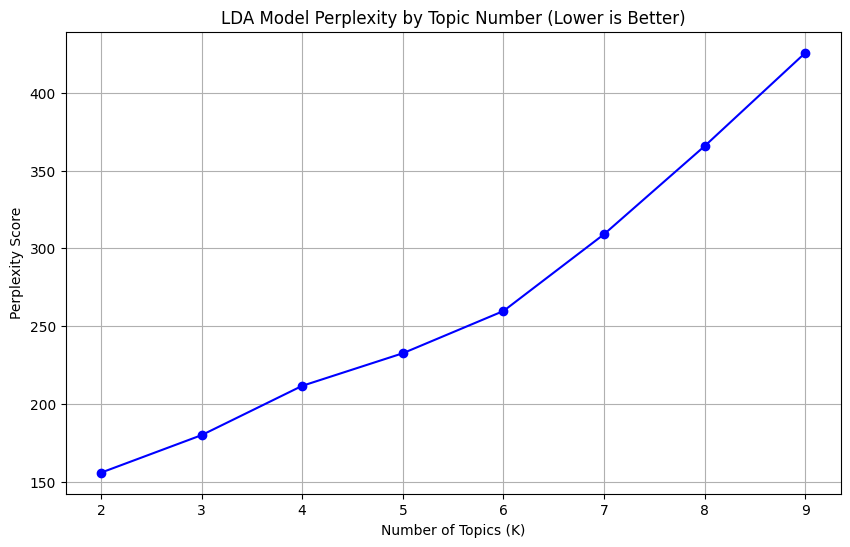

In [114]:
# LDA Modeling

n_topics = 3 # 임시 -> 이후에 적절하게 결정을 해야 할 것 같다.
lda = LatentDirichletAllocation(
    n_components = n_topics,
    random_state = 42,
    max_iter = 10,
    learning_method = 'online',
    verbose = 1,
    n_jobs = -1,
)

# K valid
perplexity_values = []
k_range = range(2, 10)

for k in k_range:
    lda = LatentDirichletAllocation(
        n_components = k,
        random_state = 42,
        max_iter = 10,
        learning_method = 'online',
        n_jobs = -1,
    )
    lda.fit(dtm)

    perp_val = lda.perplexity(dtm)
    perplexity_values.append(perp_val)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(k_range, perplexity_values, marker='o', linestyle='-', color='b')
plt.title('LDA Model Perplexity by Topic Number (Lower is Better)')
plt.xlabel('Number of Topics (K)')
plt.ylabel('Perplexity Score')
plt.grid(True)
plt.show()

In [116]:
lda = LatentDirichletAllocation(
    n_components = n_topics,
    random_state = 42,
    max_iter = 10,
    learning_method = 'online',
    verbose = 1,
    n_jobs = -1,
)

lda.fit(dtm)

# 토픽별 핵심 키워드 및 해석 출력

print("\n=== 📊 LDA 토픽별 핵심 키워드 및 해석 ===")

for idx, topic in enumerate(lda.components_):
    print("\nTopic %d:" % (idx))
    
    top_features_ind = topic.argsort()[:-11:-1]
    top_features = [feature_names[i] for i in top_features_ind]

    print(f"📌 Topic {idx}: {', '.join(top_features)}")    

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

=== 📊 LDA 토픽별 핵심 키워드 및 해석 ===

Topic 0:
📌 Topic 0: run, switch, 30, cyberpunk, 1080p, 2077, think, going, games, play

Topic 1:
📌 Topic 1: looks, steam, game, steam deck, deck, games, better, 60fps, bad, rough

Topic 2:
📌 Topic 2: looks, switch, good, handheld, pc, like, console, better, deck, game



=== 🔗 Topic vs Key Priority 매핑 (Cluster Definition) ===
key_priority    Battery  Comfort  Performance  Portability  Price  Visuals
Dominant_Topic                                                            
0                     0        0            8            0      0        1
1                     1        1           10            1      0        5
2                     1        0            7            3      1        9


C:\Users\108\AppData\Local\Temp\ipykernel_20220\2251698863.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df_valid['Dominant_Topic'] = topic_values.argmax(axis=1)


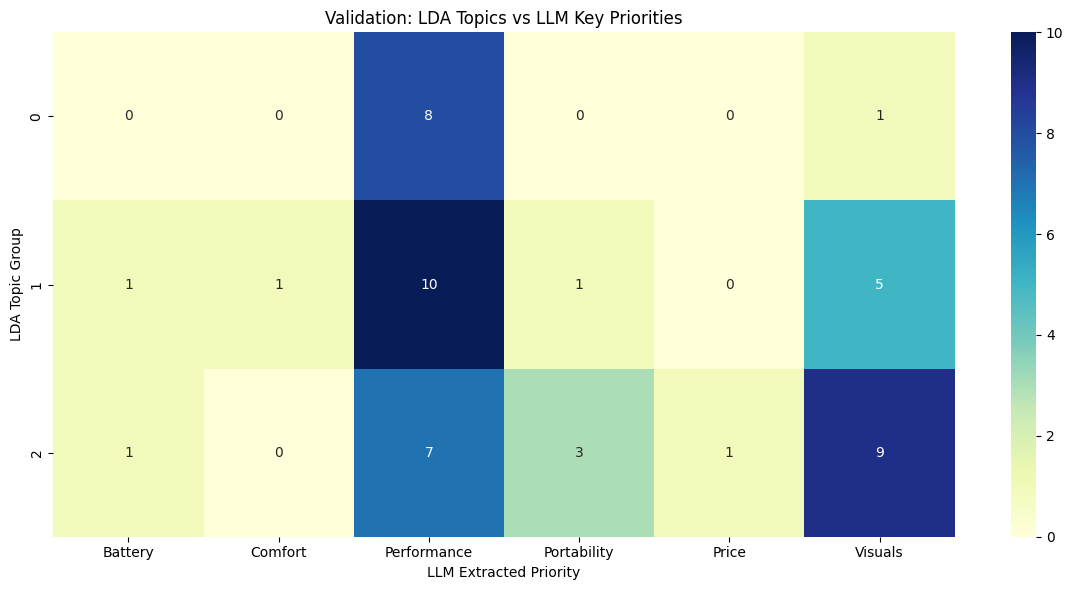

In [117]:
# 각 리뷰가 가장 높은 확률로 속하는 토픽 번호를 할당
topic_values = lda.transform(dtm)
_df_valid['Dominant_Topic'] = topic_values.argmax(axis=1)

# [핵심 과정] LLM Tag(Priority)와 LDA Topic 간의 관계 매핑
cross_tab = pd.crosstab(_df_valid['Dominant_Topic'], _df_valid['key_priority'])

print("\n=== 🔗 Topic vs Key Priority 매핑 (Cluster Definition) ===")
print(cross_tab)

# 시각화 (Heatmap)
plt.figure(figsize=(12, 6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Validation: LDA Topics vs LLM Key Priorities')
plt.ylabel('LDA Topic Group')
plt.xlabel('LLM Extracted Priority')
plt.tight_layout()
plt.show()

In [119]:
_df_valid

,Type,ID,Parent_ID,Author,User_ID,Body,Score,Date,URL,cleaned_Body,word_count,is_valid,key_priority,attributes,Dominant_Topic
0,Comment,mt9wbxh,t3_1kr1r4a,LongjumpingAd3493,t2_gtowt2szk,"This tag is wrong. Docked is 1080p 30-40, hand...",138,2025-05-20 19:52:02,https://www.reddit.com/r/consoles/comments/1kr...,"This tag is wrong. Docked is 1080p 30-40, hand...",17,True,Visuals,"[1080p, 720p]",0
2,Comment,mta7vdy,t3_1kr1r4a,goolerr,t2_1zwgv6hk,Pretty good considering it’s about the same ex...,13,2025-05-20 21:17:14,https://www.reddit.com/r/consoles/comments/1kr...,Pretty good considering it’s about the same ex...,32,True,Portability,"[handheld, form factor]",2
9,Comment,mt9x05l,t3_1kr1r4a,PugLove69,t2_19sr7hbk8w,It should have dynamic resolution like on pc a...,3,2025-05-20 19:57:30,https://www.reddit.com/r/consoles/comments/1kr...,It should have dynamic resolution like on pc a...,26,True,Performance,"[dynamic resolution, 60fps, 480p]",0
10,Comment,mta6fw9,t3_1kr1r4a,TerminaMoon,t2_xjb2j,"Not trying to knock the console, but are these...",3,2025-05-20 21:07:39,https://www.reddit.com/r/consoles/comments/1kr...,"Not trying to knock the console, but are these...",34,True,Performance,"[30fps, specs]",2
11,Comment,mta6g7t,t3_1kr1r4a,Dry-Dragonfruit-4382,t2_gartas7j,Kinda expected a bit more juice tbh. But it's ...,5,2025-05-20 21:07:43,https://www.reddit.com/r/consoles/comments/1kr...,Kinda expected a bit more juice tbh. But it's ...,28,True,Performance,[performance],2
12,Comment,mta5zwk,t3_1kr1r4a,vandridine,t2_78p79,"Unless this is your only console, it isn't wor...",2,2025-05-20 21:04:37,https://www.reddit.com/r/consoles/comments/1kr...,"Unless this is your only console, it isn't wor...",73,True,Performance,"[graphical fidelity, 720p]",1
13,Comment,mta6x88,t3_1kr1r4a,Randommer_Of_Inserts,t2_dzzz2b9g,This looks decent. I would personally never ge...,2,2025-05-20 21:10:54,https://www.reddit.com/r/consoles/comments/1kr...,This looks decent. I would personally never ge...,50,True,Portability,[optimised],2
14,Comment,mtb37mj,t3_1kr1r4a,inFINN1te,t2_15xqob,Too bad the battery will be dead within 2 hours.,2,2025-05-21 00:10:43,https://www.reddit.com/r/consoles/comments/1kr...,Too bad the battery will be dead within 2 hours.,10,True,Battery,[],1
17,Comment,mtbu16w,t3_1kr1r4a,Gytixas,t2_gdr5t,"It looks kind of good in some parts, but that ...",1,2025-05-21 02:21:05,https://www.reddit.com/r/consoles/comments/1kr...,"It looks kind of good in some parts, but that ...",49,True,Visuals,"[motion blur, upscaling]",2
18,Comment,mtc4wzw,t3_1kr1r4a,Ethereal-Throne,t2_5nq0ww6c,Barely playable for anyone who cares about exp...,1,2025-05-21 03:12:39,https://www.reddit.com/r/consoles/comments/1kr...,Barely playable for anyone who cares about exp...,19,True,Performance,[],2
